In [1]:
__file__ = 'teste'

In [2]:
"""Define configuration variables in experiment, model and training levels.

Quick Setup
===========
Change the values in the dictionary `SETUP` for a quick setup.
Documentation is provided right after each key.

Configuration
=============
More configuration options are providedin as a dictionary `CONFIG`.
`CONFIG['exp']`, `CONFIG['data']`, `CONFIG['model']`, `CONFIG['train']` and
`CONFIG['tensorflow']` define experiment-, data-, model-, training-,
TensorFlow-related configuration variables, respectively.

Note that the automatically-determined experiment name is based only on the
values defined in the dictionary `SETUP`, so remember to provide the experiment
name manually if you have changed the configuration so that you won't overwrite
existing experiment directories.
"""
import os
import shutil
import distutils.dir_util
import importlib
import numpy as np
import tensorflow as tf

# Quick setup
SETUP = {
    'model': 'musegan',
    # {'musegan', 'bmusegan'}
    # The model to use. Currently support MuseGAN and BinaryMuseGAN models.

    'exp_name': None,
    # The experiment name. Also the name of the folder that will be created
    # in './exp/' and all the experiment-related files are saved in that
    # folder. None to determine automatically. The automatically-
    # determined experiment name is based only on the values defined in the
    # dictionary `SETUP`, so remember to provide the experiment name manually
    # (so that you won't overwrite a trained model).

    'prefix': 'lastfm_alternative',
    # Prefix for the experiment name. Useful when training with different
    # training data to avoid replacing the previous experiment outputs.

    #'training_data': 'lastfm_alternative_8b_phrase',
    'training_data': 'lastfm_alternative_5b_phrase',


    # Filename of the training data. The training data can be loaded from a npy
    # file in the hard disk or from the shared memory using SharedArray package.
    # Note that the data will be reshaped to (-1, num_bar, num_timestep,
    # num_pitch, num_track) and remember to set these variable to proper values,
    # which are defined in `CONFIG['model']`.

    'training_data_location': 'sa',
    # Location of the training data. 'hd' to load from a npy file stored in the
    # hard disk. 'sa' to load from shared array using SharedArray package.

    'gpu': '0',
    # The GPU index in os.environ['CUDA_VISIBLE_DEVICES'] to use.

    'preset_g': 'hybrid',
    # MuseGAN: {'composer', 'jamming', 'hybrid'}
    # BinaryMuseGAN: {'proposed', 'proposed_small'}
    # Use a preset network architecture for the generator or set to None and
    # setup `CONFIG['model']['net_g']` to define the network architecture.

    'preset_d': 'proposed',
    # {'proposed', 'proposed_small', 'ablated', 'baseline', None}
    # Use a preset network architecture for the discriminator or set to None
    # and setup `CONFIG['model']['net_d']` to define the network architecture.

    'pretrained_dir': None,
    # The directory containing the pretrained model. None to retrain the
    # model from scratch.

    'verbose': True,
    # True to print each batch details to stdout. False to print once an epoch.

    'sample_along_training': True,
    # True to generate samples along the training process. False for nothing.

    'evaluate_along_training': True,
    # True to run evaluation along the training process. False for nothing.

    # ------------------------- For BinaryMuseGAN only -------------------------
    'two_stage_training': True,
    # True to train the model in a two-stage training setting. False to
    # train the model in an end-to-end manner.

    'training_phase': 'first_stage',
    # {'first_stage', 'second_stage'}
    # The training phase in a two-stage training setting. Only effective
    # when `two_stage_training` is True.

    'first_stage_dir': None,
    # The directory containing the pretrained first-stage model. None to
    # determine automatically (assuming using default `exp_name`). Only
    # effective when two_stage_training` is True and `training_phase` is
    # 'second_stage'.

    'joint_training': False,
    # True to train the generator and the refiner jointly. Only effective
    # when `two_stage_training` is True and `training_phase` is 'second_stage'.

    'preset_r': 'proposed_bernoulli',
    # {'proposed_round', 'proposed_bernoulli'}
    # Use a preset network architecture for the refiner or set to None and
    # setup `CONFIG['model']['net_r']` to define the network architecture.
}

CONFIG = {}

#===============================================================================
#=========================== TensorFlow Configuration ==========================
#===============================================================================
os.environ['CUDA_VISIBLE_DEVICES'] = SETUP['gpu']
CONFIG['tensorflow'] = tf.ConfigProto()
CONFIG['tensorflow'].gpu_options.allow_growth = True

#===============================================================================
#========================== Experiment Configuration ===========================
#===============================================================================
CONFIG['exp'] = {
    'model': None,
    'exp_name': None,
    'pretrained_dir': None,
    'two_stage_training': None, # For BinaryMuseGAN only
    'first_stage_dir': None, # For BinaryMuseGAN only
}

for key in ('model', 'pretrained_dir'):
    if CONFIG['exp'][key] is None:
        CONFIG['exp'][key] = SETUP[key]

if SETUP['model'] == 'musegan':
    # Set default experiment name
    if CONFIG['exp']['exp_name'] is None:
        if SETUP['exp_name'] is not None:
            CONFIG['exp']['exp_name'] = SETUP['exp_name']
        else:
            CONFIG['exp']['exp_name'] = '_'.join(
                (SETUP['prefix'], 'g', SETUP['preset_g'], 'd',
                 SETUP['preset_d']))

if SETUP['model'] == 'bmusegan':
    if CONFIG['exp']['two_stage_training'] is None:
        CONFIG['exp']['two_stage_training'] = SETUP['two_stage_training']
    # Set default experiment name
    if CONFIG['exp']['exp_name'] is None:
        if SETUP['exp_name'] is not None:
            CONFIG['exp']['exp_name'] = SETUP['exp_name']
        elif not SETUP['two_stage_training']:
            CONFIG['exp']['exp_name'] = '_'.join(
                (SETUP['prefix'], 'end2end', 'g', SETUP['preset_g'], 'd',
                 SETUP['preset_d'], 'r', SETUP['preset_r']))
        elif SETUP['training_phase'] == 'first_stage':
            CONFIG['exp']['exp_name'] = '_'.join(
                (SETUP['prefix'], SETUP['training_phase'], 'g',
                 SETUP['preset_g'], 'd', SETUP['preset_d']))
        elif SETUP['training_phase'] == 'second_stage':
            if SETUP['joint_training']:
                CONFIG['exp']['exp_name'] = '_'.join(
                    (SETUP['prefix'], SETUP['training_phase'], 'joint', 'g',
                     SETUP['preset_g'], 'd', SETUP['preset_d'], 'r',
                     SETUP['preset_r']))
            else:
                CONFIG['exp']['exp_name'] = '_'.join(
                    (SETUP['prefix'], SETUP['training_phase'], 'g',
                     SETUP['preset_g'], 'd', SETUP['preset_d'], 'r',
                     SETUP['preset_r']))
    # Set default first stage model directory
    if CONFIG['exp']['first_stage_dir'] is None:
        if SETUP['first_stage_dir'] is not None:
            CONFIG['exp']['first_stage_dir'] = SETUP['first_stage_dir']
        else:
            CONFIG['exp']['first_stage_dir'] = os.path.join(
                os.path.dirname(os.path.realpath(__file__)), 'exp',
                '_'.join((SETUP['prefix'], 'first_stage', 'g',
                          SETUP['preset_g'], 'd', SETUP['preset_d'])),
                'checkpoints')

#===============================================================================
#============================= Data Configuration ==============================
#===============================================================================
CONFIG['data'] = {
    'training_data': None,
    'training_data_location': None,
}

for key in ('training_data', 'training_data_location'):
    if CONFIG['data'][key] is None:
        CONFIG['data'][key] = SETUP[key]

#===============================================================================
#=========================== Training Configuration ============================
#===============================================================================
CONFIG['train'] = {
    'num_epoch': 20,
    'verbose': None,
    'sample_along_training': None,
    'evaluate_along_training': None,
    'two_stage_training': None, # For BinaryMuseGAN only
    'training_phase': None, # For BinaryMuseGAN only
    'slope_annealing_rate': 1.1, # For BinaryMuseGAN only
}

for key in ('verbose', 'sample_along_training', 'evaluate_along_training'):
    if CONFIG['train'][key] is None:
        CONFIG['train'][key] = SETUP[key]

if SETUP['model'] == 'bmusegan' and CONFIG['train']['training_phase'] is None:
    CONFIG['train']['training_phase'] = SETUP['training_phase']

#===============================================================================
#============================= Model Configuration =============================
#===============================================================================
CONFIG['model'] = {
    'joint_training': None, # For BinaryMuseGAN only

    # Parameters
    'batch_size': 32, # Note: tf.layers.conv3d_transpose requires a fixed batch
                      # size in TensorFlow < 1.6
    'gan': {
        'type': 'wgan-gp', # 'gan', 'wgan', 'wgan-gp'
        'clip_value': .01,
        'gp_coefficient': 10.
    },
    'optimizer': {
        # Parameters for the Adam optimizers
        'lr': .002,
        'beta1': .5,
        'beta2': .9,
        'epsilon': 1e-8
    },

    # Data
    'num_bar': 4,
    'num_beat': 4,
    'num_pitch': 84,
    'num_track': 8,
    'num_timestep': 96,
    'beat_resolution': 24,
    'lowest_pitch': 24, # MIDI note number of the lowest pitch in data tensors

    # Tracks
    'track_names': (
        'Drums', 'Piano', 'Guitar', 'Bass', 'Ensemble', 'Reed', 'Synth Lead',
        'Synth Pad'
    ),
    'programs': (0, 0, 24, 32, 48, 64, 80, 88),
    'is_drums': (True, False, False, False, False, False, False, False),

    # Network architectures (define them here if not using the presets)
    'net_g': None,
    'net_d': None,
    'net_r': None, # For BinaryMuseGAN only

    # Playback
    'pause_between_samples': 96,
    'tempo': 90.,

    # Samples
    'num_sample': 16,
    'sample_grid': (2, 8),

    # Metrics
    'metric_map': np.array([
        # indices of tracks for the metrics to compute
        [True] * 8, # empty bar rate
        [True] * 8, # number of pitch used
        [False] + [True] * 7, # qualified note rate
        [False] + [True] * 7, # polyphonicity
        [False] + [True] * 7, # in scale rate
        [True] + [False] * 7, # in drum pattern rate
        [False] + [True] * 7  # number of chroma used
    ], dtype=bool),
    'tonal_distance_pairs': [(1, 2)], # pairs to compute the tonal distance
    'scale_mask': list(map(bool, [1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1])),
    'drum_filter': np.tile([1., .1, 0., 0., 0., .1], 16),
    'tonal_matrix_coefficient': (1., 1., .5),

    # Directories
    'checkpoint_dir': None,
    'sample_dir': None,
    'eval_dir': None,
    'log_dir': None,
    'src_dir': None,
}

if SETUP['model'] == 'bmusegan' and CONFIG['model']['joint_training'] is None:
    CONFIG['model']['joint_training'] = SETUP['joint_training']

# Import preset network architectures
if CONFIG['model']['net_g'] is None:
    IMPORTED = importlib.import_module(
        '.'.join(('musegan', SETUP['model'], 'presets', 'generator',
                  SETUP['preset_g'])))
    CONFIG['model']['net_g'] = IMPORTED.NET_G

if CONFIG['model']['net_d'] is None:
    IMPORTED = importlib.import_module(
        '.'.join(('musegan', SETUP['model'], 'presets', 'discriminator',
                  SETUP['preset_d'])))
    CONFIG['model']['net_d'] = IMPORTED.NET_D

if SETUP['model'] == 'bmusegan' and CONFIG['model']['net_r'] is None:
    IMPORTED = importlib.import_module(
        '.'.join(('musegan.bmusegan.presets', 'refiner', SETUP['preset_r'])))
    CONFIG['model']['net_r'] = IMPORTED.NET_R

# Set default directories
for kv_pair in (('checkpoint_dir', 'checkpoints'), ('sample_dir', 'samples'),
                ('eval_dir', 'eval'), ('log_dir', 'logs'), ('src_dir', 'src')):
    if CONFIG['model'][kv_pair[0]] is None:
        CONFIG['model'][kv_pair[0]] = os.path.join(
            os.path.dirname(os.path.realpath(__file__)), 'exp', SETUP['model'],
            CONFIG['exp']['exp_name'], kv_pair[1])

#===============================================================================
#=================== Make directories & Backup source code =====================
#===============================================================================
# Make sure directories exist
for path in (CONFIG['model']['checkpoint_dir'], CONFIG['model']['sample_dir'],
             CONFIG['model']['eval_dir'], CONFIG['model']['log_dir'],
             CONFIG['model']['src_dir']):
    if not os.path.exists(path):
        os.makedirs(path)

# Backup source code
for path in os.listdir(os.path.dirname(os.path.realpath(__file__))):
    if os.path.isfile(path):
        if path.endswith('.py'):
            shutil.copyfile(os.path.basename(path),
                            os.path.join(CONFIG['model']['src_dir'],
                                         os.path.basename(path)))

distutils.dir_util.copy_tree(
    os.path.join(os.path.dirname(os.path.realpath(__file__)), 'musegan'),
    os.path.join(CONFIG['model']['src_dir'], 'musegan')
)


/home/eurismar/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/home/eurismar/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


['/home/eurismar/notebooks/musegan/exp/musegan/lastfm_alternative_g_hybrid_d_proposed/src/musegan/utils/image_io.py',
 '/home/eurismar/notebooks/musegan/exp/musegan/lastfm_alternative_g_hybrid_d_proposed/src/musegan/utils/metrics.py',
 '/home/eurismar/notebooks/musegan/exp/musegan/lastfm_alternative_g_hybrid_d_proposed/src/musegan/utils/__init__.py',
 '/home/eurismar/notebooks/musegan/exp/musegan/lastfm_alternative_g_hybrid_d_proposed/src/musegan/utils/ops.py',
 '/home/eurismar/notebooks/musegan/exp/musegan/lastfm_alternative_g_hybrid_d_proposed/src/musegan/utils/midi_io.py',
 '/home/eurismar/notebooks/musegan/exp/musegan/lastfm_alternative_g_hybrid_d_proposed/src/musegan/utils/neuralnet.py',
 '/home/eurismar/notebooks/musegan/exp/musegan/lastfm_alternative_g_hybrid_d_proposed/src/musegan/utils/__pycache__/image_io.cpython-36.pyc',
 '/home/eurismar/notebooks/musegan/exp/musegan/lastfm_alternative_g_hybrid_d_proposed/src/musegan/utils/__pycache__/midi_io.cpython-36.pyc',
 '/home/eurisma

In [3]:
CONFIG['data']['training_data_location'] 

'sa'

In [4]:
shape = (-1, CONFIG['model']['num_bar'], CONFIG['model']['num_timestep'],
        CONFIG['model']['num_pitch'], CONFIG['model']['num_track'])

In [5]:
shape

(-1, 4, 96, 84, 8)

In [6]:
CONFIG['exp']['model']

'musegan'

In [7]:
CONFIG['tensorflow']

gpu_options {
  allow_growth: true
}

In [8]:
CONFIG['exp']['model']

'musegan'

In [9]:
config = CONFIG['model']

In [10]:
config['net_g']['z_dim_shared']

32

In [11]:
z = {}

In [12]:
config['batch_size']

32

In [13]:
config['net_g']['z_dim_shared']

32

In [14]:
z['shared'] = tf.placeholder(
                tf.float32, (config['batch_size'],
                             config['net_g']['z_dim_shared']), 'z_shared'
            )

In [15]:
z

{'shared': <tf.Tensor 'z_shared:0' shape=(32, 32) dtype=float32>}

In [16]:
z

{'shared': <tf.Tensor 'z_shared:0' shape=(32, 32) dtype=float32>}

In [17]:
z['shared']

<tf.Tensor 'z_shared:0' shape=(32, 32) dtype=float32>

In [18]:
teste = z['shared']

In [19]:
teste

<tf.Tensor 'z_shared:0' shape=(32, 32) dtype=float32>

In [20]:
a = {}

In [21]:
a['teste'] = 3 * 4

In [22]:
a

{'teste': 12}

In [23]:
a['teste']

12

In [24]:
config['net_g']['z_dim_private']

32

In [25]:
config['net_g']['bar_generator_type']

'private'

In [26]:
!ls

config.py		      LICENSE.txt  __pycache__	  Untitled.ipynb
docs			      main.py	   README.md	  v1
exp			      musegan	   test
lastfm_alternative_5b_phrase  pretrained   training_data


In [27]:
%cd training_data/

/home/eurismar/notebooks/musegan/training_data


In [28]:
!ls

download_all.sh
download.sh
https___www_bernardmarr_com_pdf_asp_contentID=719.pdf
lastfm_alternative_5b_phrase.npy
lastfm_alternative_8b_phrase.npy
lpd
lpd_full.tar.gz
open?id=1md7aRHa7KZQhmzNBaFm0zp_SP-cHJZpP
README.md
store_to_sa.py
Untitled.ipynb


In [29]:
%cd ..

/home/eurismar/notebooks/musegan


In [30]:
!python training_data/store_to_sa.py training_data/lastfm_alternative_5b_phrase.npy

Successfully saved: lastfm_alternative_5b_phrase, (2074, 6, 4, 96, 84, 5), bool


In [31]:
CONFIG['data']['training_data']

'lastfm_alternative_5b_phrase'

In [32]:
import SharedArray as sa

In [33]:
x_train = sa.attach(CONFIG['data']['training_data'])

In [34]:
x_train.shape

(2074, 6, 4, 96, 84, 5)

In [35]:
x_train = x_train.reshape(
    -1, CONFIG['model']['num_bar'], CONFIG['model']['num_timestep'],
    CONFIG['model']['num_pitch'], CONFIG['model']['num_track'])

ValueError: cannot reshape array of size 2006968320 into shape (4,96,84,8)

Hello, you can prepare this file by yourself. 'tra_X_phrase_all' is an ".npy" file and its shape is
(# of samples, # of time steps, range of pitch, # of track).

For example, in one of our case is (50266, 384, 84, 5). It means:
(a) we have 50266 phrases for training
(b) 96 (time resolution) x 4 (# of bar), so we have 384 time steps
(c) we use 7 octave so the range of pitches is 84 (12 x 7)
(d) there are five tracks

We encourage you to prepare your own dataset. You can select desired genres and combine tracks arbitrarily after finishing the pre-processing part.

In [ ]:
96*4

In [ ]:
!ls

In [ ]:
file = "/home/eurismar/notebooks/musegan/training_data/lpd/lpd_full/0/0a0a2b0e4d3b7bf4c5383ba025c4683e.npz"

In [ ]:
data = np.load(file)

In [ ]:
type(data)

In [ ]:
data

In [ ]:
for item in data:
    print(item)

In [ ]:
data['pianoroll_0_csc_indices']

In [ ]:
data['pianoroll_0_csc_shape']

In [ ]:
data['tempo']

In [ ]:
data['tempo'].shape

In [ ]:
data['pianoroll_0_csc_indptr']

In [ ]:
data['pianoroll_0_csc_indptr'].shape

In [ ]:
data['pianoroll_0_csc_indices'].shape

# Pianoroll Exemplo

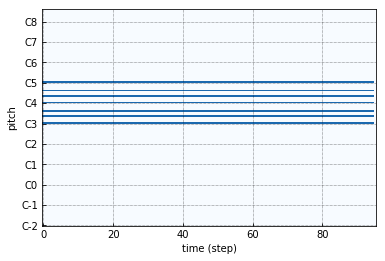

In [36]:
import numpy as np
from pypianoroll import Multitrack, Track
from matplotlib import pyplot as plt

# Create a piano-roll matrix, where the first and second axes represent time
# and pitch, respectively, and assign a C major chord to the piano-roll
pianoroll = np.zeros((96, 128))
C_maj = [60, 64, 67, 72, 76, 79, 84]
pianoroll[0:95, C_maj] = 100

# Create a `pypianoroll.Track` instance
track = Track(pianoroll=pianoroll, program=0, is_drum=False,
              name='my awesome piano')

# Plot the piano-roll
fig, ax = track.plot()
plt.show()

In [38]:
pianoroll.shape

(96, 128)

In [39]:
pianoroll

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [41]:
data = np.load("/home/eurismar/notebooks/musegan/training_data/lpd/lpd_full/0/0a0a2b0e4d3b7bf4c5383ba025c4683e.npz")

In [42]:
data

In [44]:
for item in data:
    print(item)

pianoroll_0_csc_indptr
pianoroll_0_csc_indices
pianoroll_2_csc_indices
pianoroll_2_csc_shape
pianoroll_1_csc_indptr
pianoroll_3_csc_indptr
pianoroll_1_csc_indices
pianoroll_3_csc_shape
pianoroll_0_csc_data
pianoroll_1_csc_data
pianoroll_1_csc_shape
tempo
pianoroll_4_csc_indices
pianoroll_3_csc_indices
pianoroll_4_csc_shape
pianoroll_2_csc_data
pianoroll_3_csc_data
pianoroll_4_csc_data
pianoroll_4_csc_indptr
pianoroll_2_csc_indptr
downbeat
pianoroll_0_csc_shape
info.json


In [45]:
data['info.json']

b'{"name": "0a0a2b0e4d3b7bf4c5383ba025c4683e", "1": {"is_drum": false, "program": 36, "name": "base2"}, "0": {"is_drum": true, "program": 4, "name": "Drums2"}, "3": {"is_drum": false, "program": 22, "name": "voice2"}, "2": {"is_drum": false, "program": 18, "name": "piano2"}, "4": {"is_drum": false, "program": 0, "name": "piano23"}, "beat_resolution": 24}'

In [46]:
info = data['info.json']

In [47]:
info

b'{"name": "0a0a2b0e4d3b7bf4c5383ba025c4683e", "1": {"is_drum": false, "program": 36, "name": "base2"}, "0": {"is_drum": true, "program": 4, "name": "Drums2"}, "3": {"is_drum": false, "program": 22, "name": "voice2"}, "2": {"is_drum": false, "program": 18, "name": "piano2"}, "4": {"is_drum": false, "program": 0, "name": "piano23"}, "beat_resolution": 24}'

In [53]:
data['tempo']

array([120., 120., 120., ..., 120., 120., 120.])

In [54]:
data

In [55]:
for item in data:
    print(item)

pianoroll_0_csc_indptr
pianoroll_0_csc_indices
pianoroll_2_csc_indices
pianoroll_2_csc_shape
pianoroll_1_csc_indptr
pianoroll_3_csc_indptr
pianoroll_1_csc_indices
pianoroll_3_csc_shape
pianoroll_0_csc_data
pianoroll_1_csc_data
pianoroll_1_csc_shape
tempo
pianoroll_4_csc_indices
pianoroll_3_csc_indices
pianoroll_4_csc_shape
pianoroll_2_csc_data
pianoroll_3_csc_data
pianoroll_4_csc_data
pianoroll_4_csc_indptr
pianoroll_2_csc_indptr
downbeat
pianoroll_0_csc_shape
info.json


In [57]:
x_train = sa.attach(CONFIG['data']['training_data'])

In [58]:
x_train.shape

(2074, 6, 4, 96, 84, 5)

In [59]:
x_train_1 = x_train[0]

In [60]:
x_train_1

array([[[[[False, False, False, False, False],
          [False, False, False, False, False],
          [False, False, False, False, False],
          ...,
          [False, False, False, False, False],
          [False, False, False, False, False],
          [False, False, False, False, False]],

         [[False, False, False, False, False],
          [False, False, False, False, False],
          [False, False, False, False, False],
          ...,
          [False, False, False, False, False],
          [False, False, False, False, False],
          [False, False, False, False, False]],

         [[False, False, False, False, False],
          [False, False, False, False, False],
          [False, False, False, False, False],
          ...,
          [False, False, False, False, False],
          [False, False, False, False, False],
          [False, False, False, False, False]],

         ...,

         [[False, False, False, False, False],
          [False, False, False, False, Fa

### página 5 slide https://salu133445.github.io/musegan/pdf/musegan-aaai2018-slides.pdf

In [65]:
_,_, num_bar, num_timestep, num_pitch, num_track = x_train.shape

In [66]:
x_train.shape

(2074, 6, 4, 96, 84, 5)

In [67]:
num_bar

4

In [68]:
num_timestep

96

In [69]:
num_pitch

84

In [70]:
num_track

5

In [72]:
2074*6 #contains 12,444 four-bar phrases

12444

### teste com reshape

In [83]:
x = np.random.randn(3,2)

In [85]:
x.shape

(3, 2)

In [86]:
x

array([[ 0.58439223, -1.75494801],
       [ 0.89833176,  1.33722465],
       [ 0.9161476 ,  0.2505769 ]])

In [87]:
y = x.reshape(1,2,3)

In [88]:
y.shape

(1, 2, 3)

In [89]:
y

array([[[ 0.58439223, -1.75494801,  0.89833176],
        [ 1.33722465,  0.9161476 ,  0.2505769 ]]])

In [91]:
x_train.shape

(2074, 6, 4, 96, 84, 5)

In [92]:
CONFIG['model']['num_bar'], CONFIG['model']['num_timestep'],CONFIG['model']['num_pitch'], CONFIG['model']['num_track']

(4, 96, 84, 8)

In [93]:
x_train1 = x_train.reshape(-1,4,96,84,5)

In [103]:
x_train1.shape

(12444, 4, 96, 84, 5)

In [96]:
x.shape

(3, 2)

In [102]:
y = x.reshape(-1,2)

In [99]:
y

array([[ 0.58439223, -1.75494801],
       [ 0.89833176,  1.33722465],
       [ 0.9161476 ,  0.2505769 ]])

In [100]:
y.shape

(3, 2)

In [81]:
 # Reshape data
x_train_ = x_train.reshape(-1, CONFIG['model']['num_bar'], CONFIG['model']['num_timestep'],CONFIG['model']['num_pitch'], CONFIG['model']['num_track'])
print('Training set size:', len(x_train))

ValueError: cannot reshape array of size 2006968320 into shape (4,96,84,8)

In [80]:
CONFIG['model']['num_bar'], CONFIG['model']['num_timestep'],CONFIG['model']['num_pitch'], CONFIG['model']['num_track']

(4, 96, 84, 8)